# Full domain analysis: n-quantile comparison preprocessing

Just out of curiousity, we will see if downscaling full domain is achievable in reasonable time. 

In [10]:
# config cell
import warnings
from pathlib import Path
import cftime
import dask
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt
from pyproj import Proj
from xclim import units, sdba, indices
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
import hvplot.xarray
import panel as pn
import shutil
from scipy.stats import cramervonmises_2samp

pn.extension(comms="vscode")
# for reloading the baeda module which is actively developing
import baeda
from importlib import reload

reload(baeda)

zarr_dir = Path("/center1/CMIP6/kmredilla/cmip6_4km_downscaling/cmip6_zarr")
era5_dir = Path("/center1/CMIP6/kmredilla/cmip6_4km_downscaling/era5_zarr")

# tmp dir for writing downscaled data
tmp_dir = Path("/center1/CMIP6/kmredilla/downscaling/eda")
# template filename for downscaled outputs
tmp_nq_fn = "nq{n_quantiles}_{var_id}_{model}_{scenario}.zarr"

# era5 precip indicators file
era5_idx_fp = tmp_dir.joinpath("pridx_era5.zarr")

n_quantiles_list = [50, 75, 100, 150, 200, 250]

index_name_lu = {
    "pr": {
        "rx1day": "Max 1-day precip",
        "rx5day": "Max 5-day precip",
        "cdd": "Consecutive dry Days",
        "cwd": "Consecutive wet days",
    }
}

# Processing

This section is for running the downscaling and computing indicators. It saves the output to a temporary directory and so need not be run if outputs for the visualization section already exist. 

In [3]:
# client = Client(n_workers=12, threads_per_worker=2)

# for interactive nb testing
cluster = SLURMCluster(
    cores=28,
    processes=14,
    # n_workers=14,
    memory="128GB",
    # queue="debug",
    queue="t2small",
    # walltime="01:00:00",
    walltime="12:00:00",
    log_directory="/beegfs/CMIP6/kmredilla/tmp/dask_jobqueue_logs",
    account="cmip6",
    interface="ib0",
)
client = Client(cluster)

/home/kmredilla/miniconda3/envs/cmip6-utils/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46861 instead
  warnings.warn(


In [4]:
# big cluster for fast processing!
cluster.scale(n=140)

# lil cluster for testing
# cluster.scale(n=28)

In [5]:
# connect to ERA5 data
era5_stores = {
    # "t2max": era5_dir.joinpath("t2max_era5.zarr"),
    "pr": era5_dir.joinpath("pr_era5.zarr"),
}

era5_ds = baeda.open_era5_dataset(era5_stores)

In [6]:
# run ERA5 indicators
if not era5_idx_fp.exists():
    var_id = "pr"
    era5_idx = baeda.run_indicators(era5_ds[var_id], indices=["rx1day"])
    shutil.rmtree(era5_idx_fp, ignore_errors=True)
    _ = era5_idx.to_zarr(era5_idx_fp)

Train and adjust for three different window sizes:

In [8]:
def run_quantile_adjustments(model, scenario, var_id, zarr_dir, era5_ds, tmp_dir):
    print(
        "Running historical adjustments for different numbers of quantiles for model: ",
        model,
    )
    hist, sim = baeda.extract_time_series_from_zarr(
        zarr_dir, model, scenario, var_id, coords=None
    )

    # QDM: train the adjustment
    # rechunking to allow for more workers
    chunk_kwargs = {"time": -1, "x": 10, "y": 10}
    train_kwargs = dict(
        ref=era5_ds[var_id].chunk(**chunk_kwargs),
        # think having experiment coordinate may quietly prevent
        # adjustment of data with different coordinates (e.g. ssp's)
        hist=hist.chunk(**chunk_kwargs)
        .isel(Method=0, experiment=0)
        .drop_vars(["Method", "experiment"]),
        group="time.dayofyear",
        kind=baeda.varid_adj_kind_lu[var_id],
    )
    if var_id in baeda.adapt_freq_thresh_lu:
        train_kwargs.update(
            adapt_freq_thresh=baeda.adapt_freq_thresh_lu[var_id],
            jitter_under_thresh_value=baeda.jitter_under_thresh_lu[var_id],
        )

    for n_quantiles in n_quantiles_list:
        train_kwargs.update(
            nquantiles=n_quantiles,
        )
        print(f"Training with nquantiles: {n_quantiles}")

        qdm_train = sdba.QuantileDeltaMapping.train(**train_kwargs)

        hist_adj = (
            qdm_train.adjust(
                hist.chunk(**chunk_kwargs),
                extrapolation="constant",
                interp="nearest",
            )
            .isel(Method=0, drop=True)
            .assign_coords(n_quantiles=n_quantiles)
            .expand_dims("n_quantiles")
            .transpose("n_quantiles", "experiment", "time", "y", "x")
        )
        hist_adj.name = var_id

        # compute
        hist_adj = hist_adj.load()

        # write
        out_fp = tmp_dir.joinpath(
            tmp_nq_fn.format(
                n_quantiles=n_quantiles,
                var_id=var_id,
                model=model,
                scenario="historical",
            )
        )
        if out_fp.exists():
            print("Deleting existing zarr store: ", out_fp)
            shutil.rmtree(out_fp, ignore_errors=True)
        hist_adj.to_dataset().to_zarr(out_fp)


def run_historical_quantile_indicators(model, var_id, tmp_target_dir):
    print("Running historical indicators for different window sizes for model: ", model)
    for n_quantiles in n_quantiles_list:
        hist_adj = xr.open_zarr(
            tmp_target_dir.joinpath(
                tmp_nq_fn.format(
                    n_quantiles=n_quantiles,
                    var_id=var_id,
                    model=model,
                    scenario="historical",
                )
            )
        )
        hist_idx = baeda.run_indicators(hist_adj[var_id], indices=["rx1day"])
        hist_idx_fp = tmp_target_dir.joinpath(
            tmp_nq_fn.format(
                n_quantiles=n_quantiles,
                var_id=var_id + "idx",
                model=model,
                scenario="historical",
            )
        )
        if hist_idx_fp.exists():
            print("Deleting existing zarr store: ", hist_idx_fp)
            shutil.rmtree(hist_idx_fp, ignore_errors=True)
        hist_idx.to_zarr(hist_idx_fp)

In [ ]:
# long-running cell alert. this cell took 4 hours to run on 140 workers across 10 nodes.
# but it was worth it! - Copilot lol
# It adjusts historical data for the four different window sizes and the three different adapt_freq thresholds
scenario = "ssp585"
var_id = "pr"


for model in ["GFDL-ESM4", "NorESM2-MM", "EC-Earth3-Veg"]:
    print(f"Running {model}")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        run_quantile_adjustments(model, scenario, var_id, zarr_dir, era5_ds, tmp_dir)
        run_historical_quantile_indicators(model, var_id, tmp_dir)

Running GFDL-ESM4
Running historical adjustments for different numbers of quantiles for model:  GFDL-ESM4
Training with nquantiles: 50
Training with nquantiles: 75
Training with nquantiles: 100
Training with nquantiles: 150
Training with nquantiles: 200
Training with nquantiles: 250
Running historical indicators for different window sizes for model:  GFDL-ESM4
Running NorESM2-MM
Running historical adjustments for different numbers of quantiles for model:  NorESM2-MM
Training with nquantiles: 50
Training with nquantiles: 75
Training with nquantiles: 100
Training with nquantiles: 150
Training with nquantiles: 200
Training with nquantiles: 250
Running historical indicators for different window sizes for model:  NorESM2-MM
Running EC-Earth3-Veg
Running historical adjustments for different numbers of quantiles for model:  EC-Earth3-Veg
Training with nquantiles: 50
Training with nquantiles: 75
Training with nquantiles: 100
Training with nquantiles: 150
Training with nquantiles: 200
Training 

In [12]:
cluster.close()

In [46]:
cluster.scale(n=28)

In [ ]:
# run the pixelwise Cramer von mises test for the Rx1day indicator for the different window sizes and combine
era5_idx = xr.open_zarr(era5_idx_fp)
era5_idx.load()

var_id = "pr"
models = ["GFDL-ESM4", "NorESM2-MM", "EC-Earth3-Veg"]
cvm_datasets = []
for window in window_sizes:
    for model in models:
        hist_idx = xr.open_zarr(
            tmp_target_dir.joinpath(
                tmp_fn.format(
                    qm_window=window,
                    var_id=var_id + "idx",
                    model=model,
                    scenario="historical",
                )
            )
        )

        hist_idx = (
            hist_idx.isel(experiment=0, drop=True)
            .assign_coords(model=model)
            .expand_dims("model")
        )
        hist_idx.load()

        cvm = cramervonmises_2samp(
            hist_idx["rx1day"].values.squeeze(),
            era5_idx["rx1day"].values.squeeze(),
            method="asymptotic",
        )

        dims = {dim: size for dim, size in hist_idx.sizes.items() if dim != "time"}
        new_ds = xr.Dataset(
            {
                "pvalue": (dims.keys(), np.expand_dims(cvm.pvalue, axis=[0, 1])),
            },
            coords={dim: hist_idx.coords[dim] for dim in dims.keys()},
        )
        cvm_datasets.append(new_ds)

cvm_win_ds = xr.merge(cvm_datasets)

### Domain-wide boxplots of 2-sample Cramér–von Mises $p$-values for four different day-of-year grouping window sizes

<Axes: xlabel='model', ylabel='pvalue'>

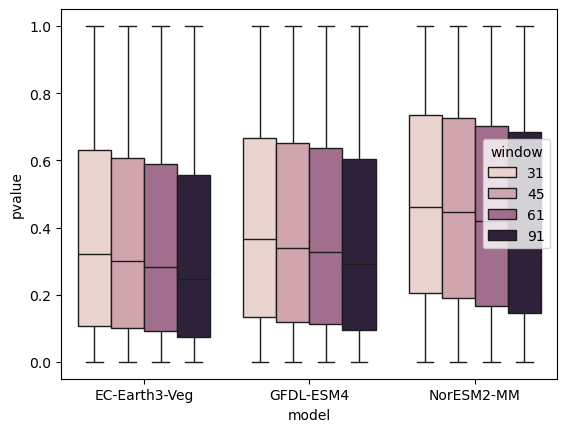

In [52]:
df = cvm_win_ds.to_dataframe().reset_index()[["model", "window", "pvalue"]]
sns.boxplot(df, x="model", y="pvalue", hue="window")

In [ ]:
# run the pixelwise Cramer von mises test for the Rx1day indicator
# for the different frequency adaptation thresholds and combine

var_id = "pr"
models = ["GFDL-ESM4", "NorESM2-MM", "EC-Earth3-Veg"]
cvm_datasets = []
for adapt_freq in adapt_freq_threhsolds:
    for model in models:
        hist_idx = xr.open_zarr(
            tmp_target_dir.joinpath(
                tmp_adapt_freq_fn.format(
                    adapt_freq=adapt_freq.replace(" ", ""),
                    var_id=var_id + "idx",
                    model=model,
                    scenario="historical",
                )
            )
        )
        hist_idx.load()
        hist_idx = hist_idx.assign_coords(model=model).expand_dims("model")

        cvm = cramervonmises_2samp(
            hist_idx["rx1day"].values.squeeze(),
            era5_idx["rx1day"].values.squeeze(),
            method="asymptotic",
        )

        dims = {dim: size for dim, size in hist_idx.sizes.items() if dim != "time"}
        new_ds = xr.Dataset(
            {
                "pvalue": (dims.keys(), np.expand_dims(cvm.pvalue, axis=[0, 1])),
            },
            coords={dim: hist_idx.coords[dim] for dim in dims.keys()},
        )
        cvm_datasets.append(new_ds)

cvm_adapt_freq_ds = xr.merge(cvm_datasets)

### Domain-wide boxplots of 2-sample Cramér–von Mises $p$-values for four different frequency adaptation thresholds

<Axes: xlabel='model', ylabel='pvalue'>

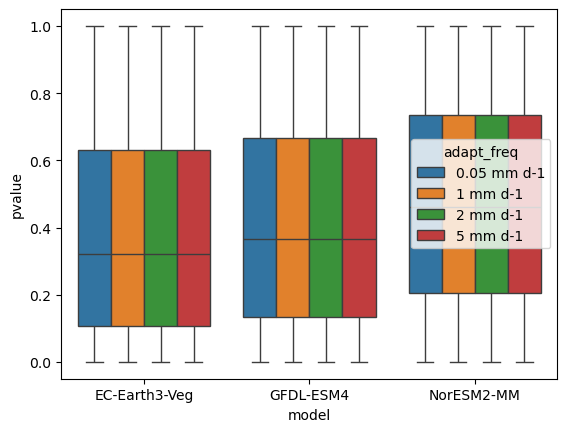

In [14]:
df = cvm_adapt_freq_ds.to_dataframe().reset_index()[["model", "adapt_freq", "pvalue"]]
sns.boxplot(df, x="model", y="pvalue", hue="adapt_freq")

### Mean Rx1day deltas (GCM - ERA5) for four different frequency adaptation thresholds:

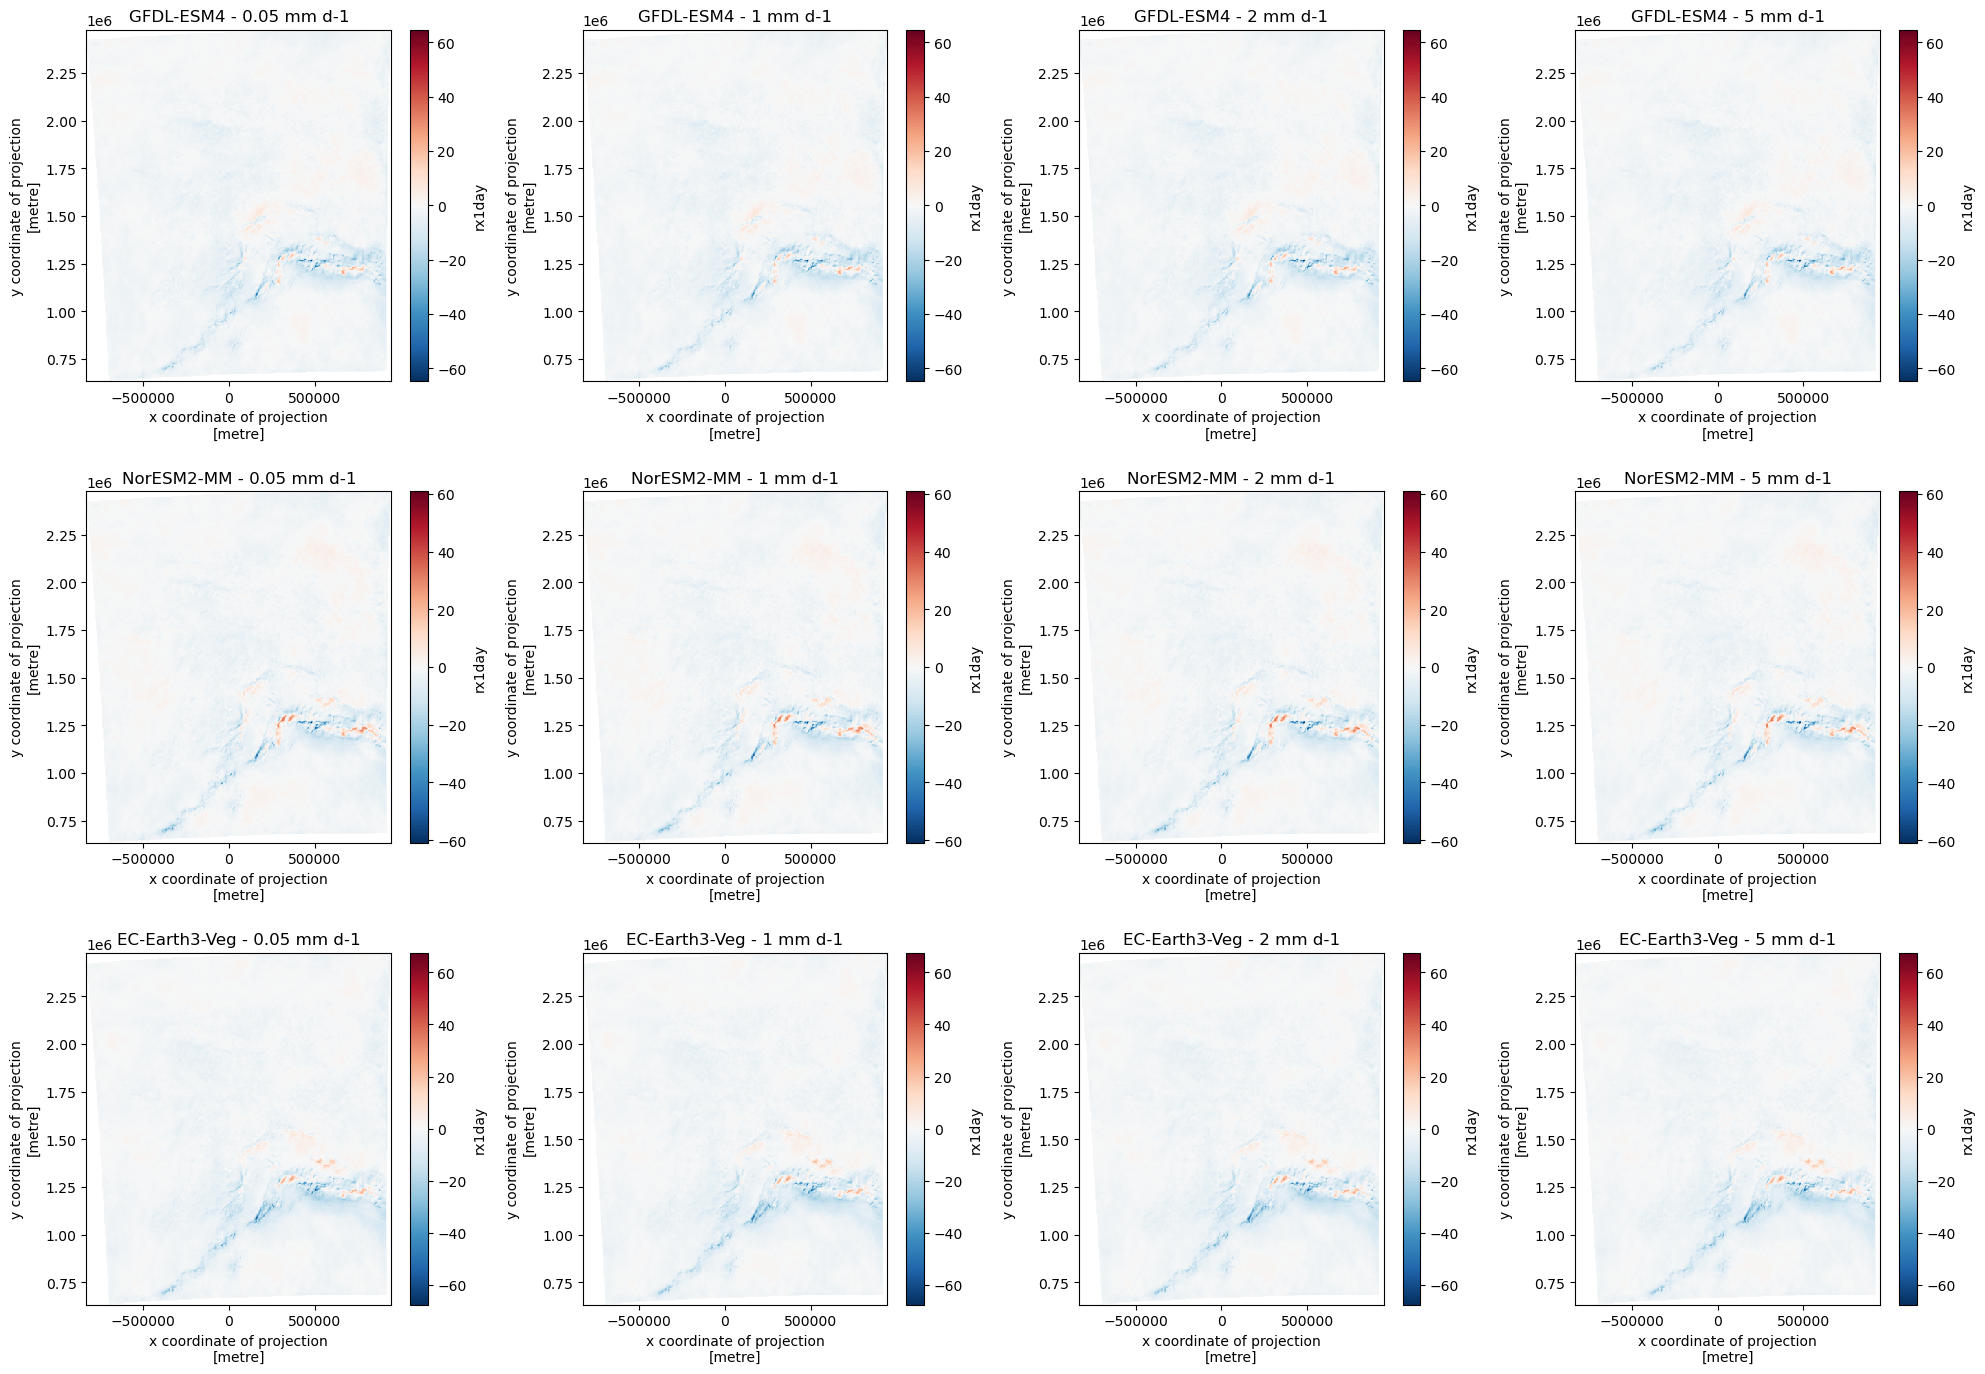

In [ ]:
# plot the deltas between the reference and various adjusted historical datasets
fig, axes = plt.subplots(3, 4, figsize=(20, 14))

var_id = "pr"
for i, adapt_freq in enumerate(adapt_freq_threhsolds):
    for j, model in enumerate(models):
        hist_idx = xr.open_zarr(
            tmp_target_dir.joinpath(
                tmp_adapt_freq_fn.format(
                    adapt_freq=adapt_freq.replace(" ", ""),
                    var_id=var_id + "idx",
                    model=model,
                    scenario="historical",
                )
            )
        )
        hist_idx.load()
        hist_idx = (
            hist_idx.isel(adapt_freq=0, drop=True)
            .assign_coords(model=model)
            .expand_dims("model")
        )

        rx1day_delta = hist_idx["rx1day"].mean("time") - era5_idx["rx1day"].mean("time")
        rx1day_delta.plot(ax=axes[j, i])
        axes[j, i].set_title(f"{model} - {adapt_freq}")

plt.tight_layout()
plt.show()

In [ ]:
adapt_freq = "0.05 mm d-1"
fp = tmp_target_dir.joinpath(
    tmp_adapt_freq_fn.format(
        adapt_freq=adapt_freq.replace(" ", ""),
        var_id=var_id,
        model=model,
        scenario="historical",
    )
)
hist_adj1 = xr.open_zarr(fp)

In [53]:
hist_adj1

<xarray.Dataset> Size: 15GB
Dimensions:     (adapt_freq: 1, time: 18250, y: 460, x: 443)
Coordinates:
  * adapt_freq  (adapt_freq) <U11 44B '0.05 mm d-1'
  * time        (time) object 146kB 1965-01-01 00:00:00 ... 2014-12-31 00:00:00
  * x           (x) float64 4kB -8.277e+05 -8.237e+05 ... 9.402e+05 9.442e+05
  * y           (y) float64 4kB 2.476e+06 2.472e+06 ... 6.402e+05 6.362e+05
Data variables:
    pr          (adapt_freq, time, y, x) float32 15GB dask.array<chunksize=(1, 1141, 29, 28), meta=np.ndarray>

In [ ]:
adapt_freq = "1 mm d-1"
fp = tmp_target_dir.joinpath(
    tmp_adapt_freq_fn.format(
        adapt_freq=adapt_freq.replace(" ", ""),
        var_id=var_id,
        model=model,
        scenario="historical",
    )
)
hist_adj2 = xr.open_zarr(fp)

In [ ]:
test = hist_adj1["pr"].isel(adapt_freq=0, drop=True).groupby("time.year").max(
    "time"
) - hist_adj2["pr"].isel(adapt_freq=0, drop=True).groupby("time.year").max("time")

In [48]:
diff = hist_adj1.isel(adapt_freq=0, drop=True) - hist_adj2.isel(adapt_freq=0, drop=True)

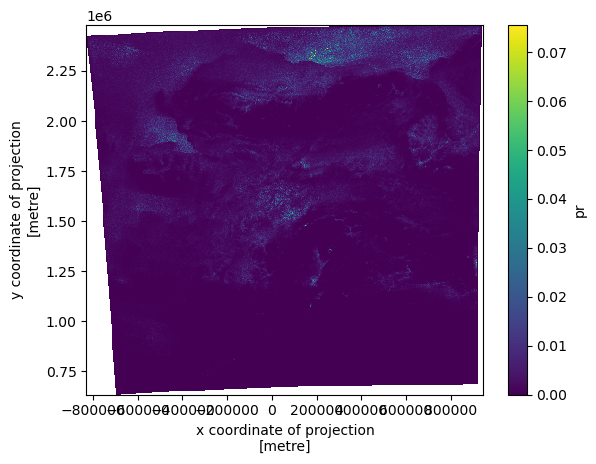

In [51]:
diff["pr"].max("time").plot()

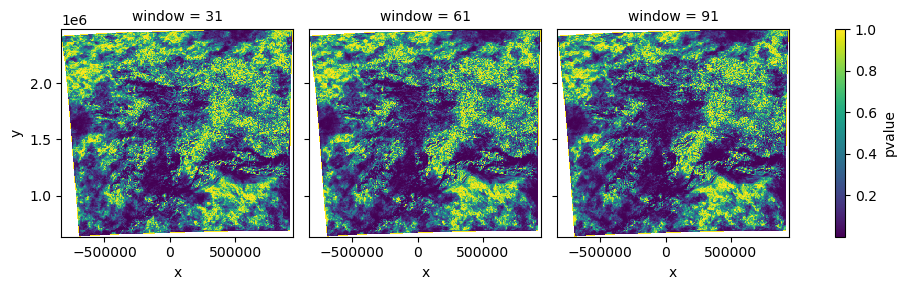

In [89]:
cvm_ds["pvalue"].plot(col="window", col_wrap=3, cmap="viridis")

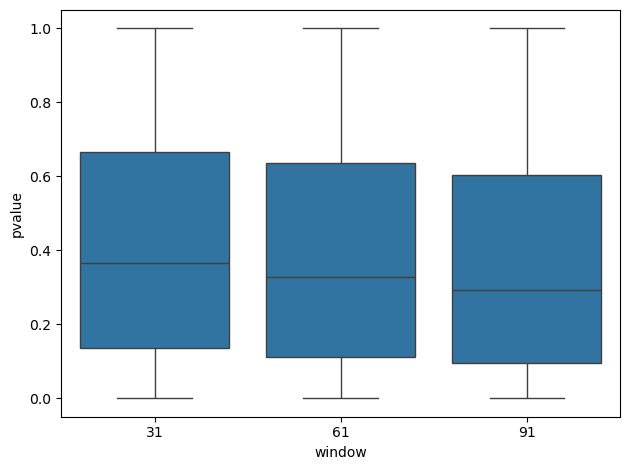

In [ ]:
pvalue_df = cvm_ds["pvalue"].to_dataframe().reset_index()[["window", "pvalue"]]

g = sns.boxplot(
    pvalue_df,
    y="pvalue",
    x="window",
)
# sns.move_legend(g, "upper left", bbox_to_anchor=(0.8, 0.3), frameon=False)
# g.figure.suptitle(indicators[indicator].attrs["long_name"])
plt.tight_layout()
plt.show()

In [34]:
# run the QDM adjustment for scenario
qm_method = "QDM"
sim_adj = (
    qdm_train.adjust(
        sim.chunk(**chunk_kwargs),
        extrapolation="constant",
        interp="nearest",
    )
    .isel(Method=0, drop=True)
    .assign_coords(Method=qm_method)
    .expand_dims("Method")
    .transpose("Method", "experiment", "time", "y", "x")
)
sim_adj.name = var_id

# compute
sim_adj = sim_adj.load()

# write
out_fp = tmp_target_dir.joinpath(
    tmp_fn.format(qm=qm_method.lower(), var_id=var_id, model=model, scenario=scenario)
)
sim_adj.to_dataset().to_zarr(out_fp)

In [ ]:
# template code for DQM configs

# adj_das = []
# for det_name, det in baeda.detrend_configs.items():
#     scen = dqm_train.adjust(
#         sim,
#         extrapolation="constant",
#         interp="nearest",
#         detrend=det,
#     )
#     adj_das.append(scen)

# # run the QDM adjustment
# qdm_da = qdm_train.adjust(
#     sim,
#     extrapolation="constant",
#     interp="nearest",
# )
# adj_das.append(qdm_da)

# # combine the DQM and QDM data
# adj_da = xr.concat(adj_das, dim="Method").rename(sim.name)
# adj_da["Method"] = list(detrend_configs.keys()) + ["QDM"]
# adj_da = adj_da

In [11]:
# run historical indicators
qm_method = "QDM"
model = "NorESM2-MM"
hist_adj_fp = "/center1/CMIP6/kmredilla/cmip6_4km_downscaling/adjusted/pr_NorESM2-MM_historical_adjusted.zarr"
hist_adj_ds = xr.open_zarr(hist_adj_fp)

hist_idx = baeda.run_indicators(hist_adj_ds[var_id])
hist_idx_fp = tmp_target_dir.joinpath(
    tmp_fn.format(
        qm=qm_method.lower(), var_id=var_id + "idx", model=model, scenario="historical"
    )
)
hist_idx.to_zarr(hist_idx_fp)

/home/kmredilla/miniconda3/envs/cmip6-utils/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 69.27 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/home/kmredilla/miniconda3/envs/cmip6-utils/lib/python3.12/site-packages/dask/array/reductions.py:655: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/kmredilla/miniconda3/envs/cmip6-utils/lib/python3.12/site-packages/dask/array/reductions.py:655: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/kmredilla/miniconda3/envs/cmip6-utils/lib/python3.12/site-packages/dask/array/reductions.py:655: RuntimeWarning: All-NaN slice encountered
  return np

In [ ]:
qm_method = "QDM"
model = "EC-Earth3-Veg"
hist_adj_fp = f"/center1/CMIP6/kmredilla/cmip6_4km_downscaling/adjusted/pr_{model}_historical_adjusted.zarr"
hist_adj_ds = xr.open_zarr(hist_adj_fp)

hist_idx = baeda.run_indicators(hist_adj_ds[var_id])
hist_idx_fp = tmp_target_dir.joinpath(
    tmp_fn.format(
        qm=qm_method.lower(), var_id=var_id + "idx", model=model, scenario="historical"
    )
)
hist_idx.to_zarr(hist_idx_fp)

<xarray.Dataset> Size: 15GB
Dimensions:      (y: 460, x: 443, time: 18250)
Coordinates:
    lat          (y, x) float64 2MB dask.array<chunksize=(50, 50), meta=np.ndarray>
    lon          (y, x) float64 2MB dask.array<chunksize=(50, 50), meta=np.ndarray>
    spatial_ref  int64 8B ...
  * time         (time) object 146kB 1965-01-01 12:00:00 ... 2014-12-31 12:00:00
  * x            (x) float64 4kB -8.277e+05 -8.237e+05 ... 9.402e+05 9.442e+05
  * y            (y) float64 4kB 2.476e+06 2.472e+06 ... 6.402e+05 6.362e+05
Data variables:
    pr           (x, time, y) float32 15GB dask.array<chunksize=(50, 18250, 50), meta=np.ndarray>

# Visualization

In [ ]:
client = Client()


# connect to ERA5 data
era5_stores = {
    "t2max": era5_dir.joinpath("t2max_era5.zarr"),
    "pr": era5_dir.joinpath("pr_era5.zarr"),
}
era5_ds = baeda.open_era5_dataset(era5_stores)


# indicators
var_id = "pr"
era5_idx_fp = tmp_target_dir.joinpath(f"{var_id + 'idx'}_era5.zarr")
era5_idx = xr.open_zarr(era5_idx_fp)

/home/kmredilla/miniconda3/envs/cmip6-utils/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35223 instead
  warnings.warn(


In [ ]:
# adjusted GCM data
hist_adj_fp = tmp_target_dir.joinpath(
    tmp_fn.format(
        qm=qm_method.lower(), var_id=var_id, model=model, scenario="historical"
    )
)
hist_adj_fp = "/center1/CMIP6/kmredilla/cmip6_4km_downscaling/adjusted/pr_NorESM2-MM_historical_adjusted.zarr"
hist_adj = xr.open_zarr(hist_adj_fp)

hist_idx_fp = tmp_target_dir.joinpath(
    tmp_fn.format(
        qm=qm_method.lower(), var_id=var_id + "idx", model=model, scenario="historical"
    )
)
hist_idx = xr.open_zarr(hist_idx_fp)

## Deltas

### Monthly climatology deltas, $Downscaled - ERA5$

In [3]:
deltas = (
    hist_adj[var_id].groupby("time.month").mean()
    - era5_ds[var_id].groupby("time.month").mean()
)
deltas = deltas.load()

/home/kmredilla/miniconda3/envs/cmip6-utils/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 26.59 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [20]:
w_month = pn.widgets.IntSlider(name="Month", start=1, end=12)

# deltas_da.interactive.isel(Method=0, experiment=0, month=w_month).hvplot()#.opts(width=800, height=500)
deltas.isel(Method=0, experiment=0, drop=True).interactive.sel(month=w_month).hvplot(
    cmap="BrBG", kind="image", clabel=hist_adj[var_id].attrs["units"]
).opts(width=800, height=500)

BokehModel(combine_events=True, render_bundle={'docs_json': {'781f6f0c-afa9-4717-8fec-ae9ed1de9c73': {'version…

## Indicators

In [24]:
# just loading the indicators for quick computes
hist_idx = hist_idx.load()
era5_idx = era5_idx.load()
sim_idx = sim_idx.load()

### Indicator climatology deltas ($Downscaled - ERA5$)

In [ ]:
mean_idx_deltas = (hist_idx.mean(dim="time") - era5_idx.mean(dim="time")).isel(
    Method=0, experiment=0, drop=True
)
idx_sel = pn.widgets.Select(
    options={index_name_lu[var_id][v]: v for v in mean_idx_deltas.data_vars}
)
pn.Column(
    idx_sel, mean_idx_deltas.hvplot.image(z=idx_sel, cmap="BrBG", width=800, height=500)
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'abe16920-dcff-414c-9c20-511fb335c2bf': {'version…

In [ ]:
model = "NorESM2-MM"
hist_idx_fp = tmp_target_dir.joinpath(
    tmp_fn.format(
        qm=qm_method.lower(), var_id=var_id + "idx", model=model, scenario="historical"
    )
)
hist_idx = xr.open_zarr(hist_idx_fp)

hist_idx = hist_idx.load()
era5_idx = era5_idx.load()

mean_idx_deltas = (hist_idx.mean(dim="time") - era5_idx.mean(dim="time")).isel(
    Method=0, experiment=0, drop=True
)
idx_sel = pn.widgets.Select(
    options={index_name_lu[var_id][v]: v for v in mean_idx_deltas.data_vars}
)
pn.Column(
    idx_sel, mean_idx_deltas.hvplot.image(z=idx_sel, cmap="BrBG", width=800, height=500)
)

ValueError: Dimensions {'Method', 'experiment'} do not exist. Expected one or more of FrozenMappingWarningOnValuesAccess({'x': 443, 'y': 460})

In [ ]:
tmp_da = hist_idx.mean(dim="time").isel(Method=0, experiment=0, drop=True)
idx_sel = pn.widgets.Select(
    options={index_name_lu[var_id][v]: v for v in mean_idx_deltas.data_vars}
)
pn.Column(idx_sel, tmp_da.hvplot.image(z=idx_sel, cmap="BrBG", width=800, height=500))

BokehModel(combine_events=True, render_bundle={'docs_json': {'2365e877-ea69-48af-a356-7b2472b1c6ee': {'version…

In [47]:
tmp_da = era5_idx.mean(dim="time")
idx_sel = pn.widgets.Select(
    options={index_name_lu[var_id][v]: v for v in mean_idx_deltas.data_vars}
)
pn.Column(idx_sel, tmp_da.hvplot.image(z=idx_sel, cmap="BrBG", width=800, height=500))

BokehModel(combine_events=True, render_bundle={'docs_json': {'6e641677-c422-44eb-94fa-c32a87730edd': {'version…

In [51]:
# connect to regridded GCM data
model = "GFDL-ESM4"
scenario = "ssp245"
var_id = "pr"

hist, sim = baeda.extract_time_series_from_zarr(
    zarr_dir, model, scenario, var_id, coords=None
)

In [ ]:
# wanna compare CDFs of ERA5 and GCM at this point
x = 4.839e5
y = 1.265e6

era5_extr = (
    era5_ds[var_id]
    .sel(x=x, y=y, method="nearest", drop=True)
    .assign_coords(Method="ERA5")
)
hist_extr = hist.sel(x=x, y=y, method="nearest", drop=True).isel(
    experiment=0, drop=True
)
hist_adj_extr = hist_adj.sel(x=x, y=y, method="nearest", drop=True).isel(
    experiment=0, drop=True
)

In [ ]:
df = pd.concat(
    [
        hist_extr.to_dataframe().reset_index(),
        era5_extr.to_dataframe().reset_index(),
        hist_adj_extr.to_dataframe().reset_index(),
    ]
)

<Axes: xlabel='pr', ylabel='Proportion'>

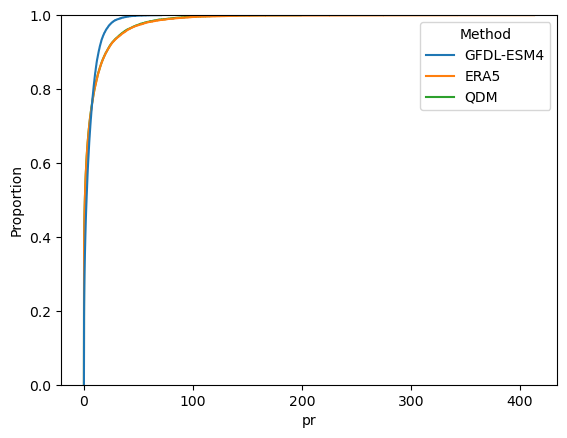

In [ ]:
sns.ecdfplot(df, x="pr", hue="Method")

<Axes: xlabel='pr', ylabel='Proportion'>

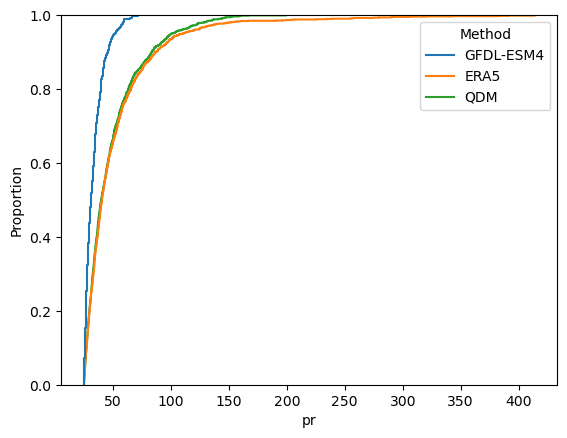

In [ ]:
sns.ecdfplot(df.query("pr > 25"), x="pr", hue="Method")

In [89]:
hist_extr.max()

<xarray.DataArray 'pr' ()> Size: 8B
array(71.49914551)

In [108]:
hist_extr.where(hist_extr == hist_extr.max(), drop=True)

<xarray.DataArray 'pr' (Method: 1, time: 1)> Size: 4B
array([[71.499146]], dtype=float32)
Coordinates:
  * time     (time) object 8B 1970-09-27 00:00:00
  * Method   (Method) <U9 36B 'GFDL-ESM4'
Attributes:
    units:          mm d-1
    standard_name:  lwe_precipitation_rate
    source_id:      GFDL-ESM4
    experiment_id:  historical

In [ ]:
prmax_doy = hist_extr.where(
    hist_extr == hist_extr.max(), drop=True
).time.dt.dayofyear.item()

In [97]:
doys = list(range(prmax_doy - 15, prmax_doy)) + list(range(prmax_doy, prmax_doy + 15))

In [ ]:
window_df = pd.concat(
    [
        hist_extr.sel(time=hist_extr.time.dt.dayofyear.isin(doys))
        .to_dataframe()
        .reset_index(),
        era5_extr.sel(time=era5_extr.time.dt.dayofyear.isin(doys))
        .assign_coords(Method="ERA5")
        .to_dataframe()
        .reset_index(),
        hist_adj_extr.sel(time=hist_adj_extr.time.dt.dayofyear.isin(doys))
        .to_dataframe()
        .reset_index(),
    ]
)

<Axes: xlabel='pr', ylabel='Proportion'>

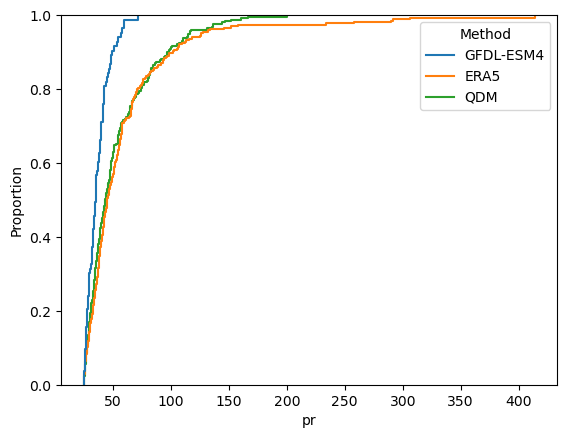

In [ ]:
sns.ecdfplot(window_df.query("pr > 25"), x="pr", hue="Method")